# 02 - Data from the Web


## You will never guess how long it takes EPFL students to complete their degree!

## Question 2 will shock you!

---

## Part 0 - Helpers and constants

#### Import modules

In [140]:
import requests

from bs4 import BeautifulSoup

import re

import pickle

import pandas as pd

#### Constants

In [141]:
# Base URL for isa.epfl.ch public report searches
isa_base_url = 'http://isa.epfl.ch/imoniteur_ISAP/'

#### Helpers

In [142]:
# Helper for creating search path
def isa_url(path):
    return isa_base_url + path

In [143]:
# Allow accessing dictionary items as object attributes
# https://goodcode.io/articles/python-dict-object/
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)

In [144]:
# Fetch the given url using a GET requests with the supplied parameters
# and return a BeautifulSoup object
def get_page(url, params=None):
    r = requests.get(url, params)
    
     # Check whether the request succeeded or not
    if r.status_code is not requests.codes.ok:
        print("Something went wrong. Got status code = %d" % r.status_code)
        return None
    
    # Make sure we actually got some content back, as ISA will return a 200 status code but no content
    # when the supplied parameters are wrong.
    if int(r.headers['Content-Length']) == 0:
        print("Something went wrong. Got Content-Length: 0")
        return None
    
    # Extract the response body
    html = r.text
    
    # Parse it with BeautifulSoup
    return BeautifulSoup(html, 'html.parser')

## Part 1 - Scraper Module

The first step is to fetch all the data from ISA.

To do this, we will have to scrape the respective frames that ISA serves for the form and then the search results. Steps are detailed below.

In [145]:
# URL of the public ISA home page.
isa_home_url = isa_url('%21gedpublicreports.htm?ww_i_reportmodel=133685247')

#### Get the right frame URL from the home page

In [146]:
# Get the home page content
home_soup = get_page(isa_home_url)

In [147]:
# Find the frame containing the form
toc_frame = home_soup.find('frame', attrs={'name': 'toc'})

In [148]:
# Extract the frame's URL
toc_frame_url = toc_frame['src']
toc_frame_url

'!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247'

#### Let's now get the form itself

In [149]:
toc_url = isa_url(toc_frame_url)

In [150]:
toc_soup = get_page(toc_url)

In [151]:
# Find the form itself within the page.
# The form's name is a heuristic, read from the page's source.
form_elem = toc_soup.find('form', attrs={'name': 'f'})

In [152]:
# Find the form's action on validation
form_action = form_elem['action']
form_action_url = isa_url(form_action)
form_action_url

'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter'

### Manually craft the same request submitting the form would send to the server

The requests below corresponds to:

**Format:** html  
**Unité academique:** Informatique  
**Période académique:** *blank*  
**Période pédagogique:** *blank*  
**Type de semestre:** *blank*  

In [153]:
# Define a payload dictionary with all the parameters expected by ISA's API endpoint

# /!\ By default we will request all possibilities from the endpoint, and then filter. /!\ #

# Example requests for specific academic or pedagogic periods are left FYI.

payload = {
    'ww_b_list': '1',
    'ww_i_reportmodel': '133685247',
    'ww_c_langue': '',
    
    # Format = html
    'ww_i_reportModelXsl': '133685270', 
    
    # Faculty = { Informatique : 249847 }
    'zz_x_UNITE_ACAD': 'Informatique',
    'ww_x_UNITE_ACAD': '249847',
    
    # Academic Period = { '' : null } if we want all possible periods
    #                 = { '2016-2017' : 355925344 } for a specific year
    'zz_x_PERIODE_ACAD': '',
    'ww_x_PERIODE_ACAD': 'null',

    
    # Pedagogic Period = { '' : null } if we want all possible periods
    #                  = { 'Bachelor semestre 1' : 249108 } for a specific period
    'zz_x_PERIODE_PEDAGO': '',
    'ww_x_PERIODE_PEDAGO': 'null',
    
    # Winter or summer semesters
    'zz_x_HIVERETE': '',
    'ww_x_HIVERETE': 'null',
    
    'dummy': 'ok'
}

#### Send the request and extract the list of links that would appear below the form had we submitted it using the browser

In [154]:
# Parse the result
form_result_soup = get_page(form_action_url, params=payload)
# form_result_soup.prettify() # Debug print

In [155]:
# Extract the links from the list of results
all_links = form_result_soup('a', class_='ww_x_GPS')
# all_links # Debug print

Store the links in a dictionary. Some cleaning is applied, such as whitespace stripping

> **Note:** We remove the first link, named 'Tous', as we will request each page individually
      in order to avoid downloading a huge HTML table, which would also be much more painful to parse.

In [156]:
links = [
    objdict({
        'text': link.text.strip(),
        'url': link.attrs['onclick']
    }) for link in all_links if link.text.strip() != 'Tous'
]

For each link,the page loads the respective results with the following on-click action :

```
loadReport('ww_x_GPS=2021043255');return false;
```

We will use the following function ```parse_url()``` to extract the ```ww_x_GPS``` parameter expected by the API to return the desired information about the students.

In [157]:
parse_url_pattern = r"""'(\w+)=(\d+)'"""
parse_url_re = re.compile(parse_url_pattern)

def parse_url(url):
    match = re.search(parse_url_pattern, url)

    if match == None:
        print('parse_url: parsing failure: %s' % url)
        return None
    
    return objdict({
        'key': match.group(1),
        'value': match.group(2)
    })

The list itself must be parsed to extract information regarding section, academic year, pedagogic period. The format is the following :

```
Informatique, 2016-2017, Bachelor semestre 1
```

We call an element of the list an item, and it will be parsed by the following ```parse_item()``` function.

In [158]:
parse_item_pattern = r"""Informatique,\s*(?P<start_year>\d+)-(?P<end_year>\d+),\s*(?P<degree>[\w]+) semestre (?P<semester>\d)"""
parse_item_re = re.compile(parse_item_pattern)

def parse_item(item, url, payload):
    match = re.match(parse_item_re, item)
    
    # The above regex will match only the kind of records we are interested in, so we can
    # safely drop all the non-matching ones
    if match == None:
        # print('Match failed: %s ' % item)
        return None
    
    parsed_url = parse_url(url)
    
    if parsed_url == None:
        return None
    
    params = payload.copy()
    params[parsed_url.key] = parsed_url.value
    
    return objdict({
        'start_year': int(match.group('start_year')),
        'end_year': int(match.group('end_year')),
        'degree': match.group('degree'),
        'semester': int(match.group('semester')),
        'params': params
    })

# Filter all None elements from the given list
def filter_none(a_list):
    return [item for item in a_list if item != None]

In [159]:
all_items = [parse_item(link.text, link.url, payload) for link in links]

In [160]:
def is_valid_item(item):
    return item != None and item.start_year >= 2007 and item.end_year <= 2017

def filter_items(items):
    return [item for item in items if is_valid_item(item)]

In [161]:
items = filter_items(all_items)


#### Going through the years to extract the list of enrolled students

In [162]:
list_page_url = isa_url('!GEDPUBLICREPORTS.html')

def parse_student_row(tr, item, headers):
    tds = tr.find_all('td')
    texts = [td.text for td in tds]
    
    res = {}
    for i, header in enumerate(headers):
        res[header] = texts[i]
    
    item_keys = ['degree', 'semester', 'start_year', 'end_year']
    for key in item_keys:
        res[key] = item[key]
    
    return objdict(res)

def parse_students_list(page_soup, item):
    table = page_soup.find('table')
    trs = table.find_all('tr')
    
    if len(trs) < 3:
        return []
    
    (header_row, students_rows) = (trs[1], trs[2:])
        
    headers = [x.text for x in header_row.find_all('th')]
    
    return [
        parse_student_row(student_row, item, headers) for student_row in students_rows
    ]

def load_student_page(item):
    return objdict({
        'soup': get_page(list_page_url, item.params),
        'item': item
    })

def flatten_list(a_list):
    return [item for sublist in a_list for item in sublist]

# TODO: Add logging statements above to see the progress

In [163]:
load_from_disk = True
save_path = "students_data.p"

if load_from_disk:
    student_list = pickle.load(open(save_path, 'rb'))
else:
    students_pages = [load_student_page(item) for item in items]

    students_lists = [
        parse_students_list(page.soup, page.item) for page in students_pages
    ]

    student_list = flatten_list(students_lists)
    
    # Serialize the whole data to disk
    pickle.dump(student_list, open(save_path, 'wb'))

## Part 2 - Data analysis

### Question 1

> Keep only the students for which you have an entry for both Bachelor semestre 1 and Bachelor semestre 6. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

In [164]:
students_data = pd.DataFrame(student_list)

def load_bsc_data(data):
    bsc_data = students_data[['No Sciper', 'Civilité', 'Nom Prénom', 'degree', 'semester', 'start_year', 'end_year']]
    return bsc_data.rename(columns={'No Sciper': 'sciper', 'Civilité': 'title', 'Nom Prénom': 'name'})
    
bsc_data = load_bsc_data(students_data)

In [165]:
def filter_bsc_students(bsc_data):
    bsc_students = bsc_data[bsc_data['degree'] == 'Bachelor']
    idx1 = set(bsc_students[bsc_students['semester'] == 1].set_index('sciper').index)
    idx6 = set(bsc_students[bsc_students['semester'] == 6].set_index('sciper').index)

    idx = idx1.intersection(idx6)

    return bsc_students[bsc_students['sciper'].isin(idx)].set_index('sciper').sort_index()

bsc = filter_bsc_students(bsc_data)
bsc

,title,name,degree,semester,start_year,end_year
sciper,,,,,,
147008,Monsieur,Good Xavier,Bachelor,4,2009,2010
147008,Monsieur,Good Xavier,Bachelor,1,2008,2009
147008,Monsieur,Good Xavier,Bachelor,2,2008,2009
147008,Monsieur,Good Xavier,Bachelor,3,2009,2010
147008,Monsieur,Good Xavier,Bachelor,6,2010,2011
147008,Monsieur,Good Xavier,Bachelor,5,2010,2011
169569,Monsieur,Arévalo Christian,Bachelor,3,2008,2009
169569,Monsieur,Arévalo Christian,Bachelor,4,2008,2009
169569,Monsieur,Arévalo Christian,Bachelor,2,2007,2008


In [166]:
def add_semesters_count(bsc):
    cols = ['sciper', 'semester']
    semester_count = bsc.reset_index()[cols].groupby('sciper').count().rename(columns={'semester': 'semester_count'})
    return bsc.merge(semester_count, left_index=True, right_index=True)
    
with_counts = add_semesters_count(bsc)
with_counts.head(20)

,title,name,degree,semester,start_year,end_year,semester_count
sciper,,,,,,,
147008,Monsieur,Good Xavier,Bachelor,4,2009,2010,6
147008,Monsieur,Good Xavier,Bachelor,1,2008,2009,6
147008,Monsieur,Good Xavier,Bachelor,2,2008,2009,6
147008,Monsieur,Good Xavier,Bachelor,3,2009,2010,6
147008,Monsieur,Good Xavier,Bachelor,6,2010,2011,6
147008,Monsieur,Good Xavier,Bachelor,5,2010,2011,6
169569,Monsieur,Arévalo Christian,Bachelor,3,2008,2009,6
169569,Monsieur,Arévalo Christian,Bachelor,4,2008,2009,6
169569,Monsieur,Arévalo Christian,Bachelor,2,2007,2008,6


In [167]:
abc = with_counts[['title', 'name', 'semester_count']].reset_index().groupby('sciper').agg('first')
abc.describe()

,semester_count
count,397.000000
mean,7.083123
std,1.524428
min,4.000000
25%,6.000000
50%,6.000000
75%,8.000000
max,12.000000


In [168]:
by_title = abc.groupby('title')
by_title['semester_count'].describe()

title          
Madame    count     29.000000
          mean       6.793103
          std        1.346406
          min        6.000000
          25%        6.000000
          50%        6.000000
          75%        8.000000
          max       11.000000
Monsieur  count    368.000000
          mean       7.105978
          std        1.536891
          min        4.000000
          25%        6.000000
          50%        6.000000
          75%        8.000000
          max       12.000000
Name: semester_count, dtype: float64

### Question 2

> Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between Master semestre 1 and Master semestre 2. If the Mineur field is not empty, the student should also appear registered in Master semestre 3. Last but not the least, don't forget to check if the student has an entry also in the Projet Master tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?

In [169]:
def load_msc_data(data):
    cols = [
        'Civilité', 'No Sciper', 'Nom Prénom', 'Statut',
        'Spécialisation', 'Mineur',
        'degree', 'semester', 'end_year', 'start_year'
    ]
    rename = {
        'Civilité': 'title',
        'No Sciper': 'sciper',
        'Nom Prénom': 'name',
        'Statut': 'status',
        'Spécialisation': 'specialisation',
        'Mineur': 'minor'
    }
    
    return students_data[cols].rename(columns=rename)
    
msc_data = load_msc_data(students_data)

def filter_msc_students(students_data):
    return students_data[(students_data['degree'] == 'Master') & (students_data['status'] == 'Présent')]

msc = filter_msc_students(msc_data).set_index('sciper').sort_index()


In [170]:
msc_count = add_semesters_count(msc)
msc_count[(msc_count['semester_count'] < 3) & (msc_count['minor'] != '')]

,title,name,status,specialisation,minor,degree,semester,end_year,start_year,semester_count
sciper,,,,,,,,,,
153642,Monsieur,Imhoff Lionel,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2008,2007,1
153645,Monsieur,Rosat Damien,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2008,2007,1
160391,Monsieur,Chipounov Vitaly,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2008,2007,1
172257,Monsieur,Dubut Frédéric,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2008,2007,1
199294,Monsieur,Jin Xuedong,Présent,,"Mineur en Management, technologie et entrepren...",Master,2,2011,2010,2
199294,Monsieur,Jin Xuedong,Présent,,"Mineur en Management, technologie et entrepren...",Master,3,2012,2011,2
200419,Monsieur,Jing Lifu,Présent,,"Mineur en Management, technologie et entrepren...",Master,2,2011,2010,2
203301,Monsieur,Nishida Keishi,Présent,,"Mineur en Management, technologie et entrepren...",Master,2,2011,2010,2
203301,Monsieur,Nishida Keishi,Présent,,"Mineur en Management, technologie et entrepren...",Master,1,2011,2010,2


In [171]:
msc_agg = msc_count[['title', 'name', 'minor', 'specialisation', 'semester_count']].reset_index().groupby('sciper').agg('first')
msc_agg.sample(10)

,title,name,minor,specialisation,semester_count
sciper,,,,,
244206,Monsieur,Doy Damien,,Computer Engineering - SP,3
178656,Monsieur,Curreli Alexandre,,Internet computing,3
192674,Monsieur,Rossier Joël,,,2
255163,Monsieur,Ionescu Vlad Nicolae,,,2
251558,Madame,Popovic Radmila,,,3
166258,Monsieur,Balet Ken,,,3
155093,Monsieur,Wafellman Jonathan,,Internet computing,2
185522,Monsieur,Stroe Dante,,,3
194430,Monsieur,Kromwijk Sander,Mineur en Biocomputing,,3


In [172]:
msc_agg[msc_agg['semester_count'] >= 1].groupby('title').describe()

semester_count
title                         
Madame   count      131.000000
         mean         2.503817
         std          1.098069
         min          1.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          7.000000
Monsieur count      834.000000
         mean         2.482014
         std          1.004330
         min          1.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          6.000000

In [173]:
parse_item_pdm_pattern = r"""Informatique,\s*(?P<start_year>\d+)-(?P<end_year>\d+),\s*Projet Master\s+(?P<season>\w+)"""
parse_item_pdm_re = re.compile(parse_item_pdm_pattern)

def parse_item_pdm(item, url, payload):
    match = re.match(parse_item_pdm_re, item)
    
    # The above regex will match only the kind of records we are interested in, so we can
    # safely drop all the non-matching ones
    if match == None:
        # print('Match failed: %s ' % item)
        return None
    parsed_url = parse_url(url)
    
    if parsed_url == None:
        return None
    
    params = payload.copy()
    params[parsed_url.key] = parsed_url.value
    
    return objdict({
        'start_year': int(match.group('start_year')),
        'end_year': int(match.group('end_year')),
        'season': match.group('season'),
        'params': params
    })


all_items_pdm = [parse_item_pdm(link.text, link.url, payload) for link in links]
items_pdm = filter_items(all_items_pdm)

In [174]:
def parse_student_row_pdm(tr, item, headers):
    tds = tr.find_all('td')
    texts = [td.text for td in tds]
    
    res = {}
    for i, header in enumerate(headers):
        res[header] = texts[i]
    
    item_keys = ['season', 'start_year', 'end_year']
    for key in item_keys:
        res[key] = item[key]
    
    return objdict(res)

def parse_students_list_pdm(page_soup, item):
    table = page_soup.find('table')
    trs = table.find_all('tr')
    
    if len(trs) < 3:
        return []
    
    (header_row, students_rows) = (trs[1], trs[2:])
        
    headers = [x.text for x in header_row.find_all('th')]
    
    return [
        parse_student_row_pdm(student_row, item, headers) for student_row in students_rows
    ]

In [175]:
pdm_students_pages = [load_student_page(item) for item in items_pdm]

pdm_students_pages

students_lists_pdm = [
    parse_students_list_pdm(page.soup, page.item) for page in pdm_students_pages
    ]

student_list_pdm = flatten_list(students_lists_pdm) 

In [176]:
len(student_list_pdm)

128

In [191]:
students_pdm_data = pd.DataFrame(student_list_pdm)
students_pdm_data.sample(10)


def load_pdm_data(data):
    pdm_data = students_pdm_data[['No Sciper', 'Civilité', 'Nom Prénom', 'Mineur', 'Statut', 'start_year', 'end_year','season']]
    return pdm_data.rename(columns={'No Sciper': 'sciper', 'Civilité': 'title', 'Nom Prénom': 'name'})
    
pdm_data = load_pdm_data(students_pdm_data)

pdm_data = pdm_data.set_index('sciper').sort_index()
pdm_data.index.is_unique

False

In [192]:
pdm_data.sample(10)

,title,name,Mineur,Statut,start_year,end_year,season
sciper,,,,,,,
200419,Monsieur,Jing Lifu,,Stage,2011,2012,printemps
202508,Monsieur,Vessaz Florian,,Présent,2016,2017,automne
203945,Monsieur,Cao Huu-Ân,"Mineur en Management, technologie et entrepren...",Présent,2016,2017,automne
179670,Monsieur,Perrenoud Basile Samuel,,Stage,2011,2012,printemps
195675,Monsieur,Schegg Elias,,Présent,2016,2017,automne
191471,Monsieur,Brot Benoît,,Présent,2010,2011,automne
173527,Monsieur,Stewart Conail,,Présent,2007,2008,automne
259766,Monsieur,Dubedat Philippe Pierre-Elie,,Présent,2016,2017,automne
166075,Monsieur,Amiguet Jérôme,,Présent,2016,2017,automne


In [196]:
msc_agg.index.is_unique

True

In [194]:
pdm_data.index.get_duplicates()

['146742', '159852', '160213', '170235', '173527', '183605', '191471']

In [195]:
pdm_data.reset_index()[pdm_data.reset_index()['sciper'].isin(pdm_data.index.get_duplicates())]

,sciper,title,name,Mineur,Statut,start_year,end_year,season
1,146742,Monsieur,Marx Clément,,Présent,2010,2011,automne
2,146742,Monsieur,Marx Clément,,Congé,2010,2011,printemps
6,159852,Monsieur,Brutsche Florian,,Congé,2007,2008,printemps
7,159852,Monsieur,Brutsche Florian,,Congé,2008,2009,automne
9,160213,Monsieur,Bécholey Alexandre,,Congé,2009,2010,printemps
10,160213,Monsieur,Bécholey Alexandre,,Présent,2009,2010,automne
19,170235,Monsieur,Gruner Samuel,,Congé,2011,2012,printemps
20,170235,Monsieur,Gruner Samuel,,Présent,2012,2013,automne
29,173527,Monsieur,Stewart Conail,,Présent,2007,2008,automne
30,173527,Monsieur,Stewart Conail,,Présent,2007,2008,printemps


In [256]:
msc_agg_pdm = msc_agg.sort_index()
pdm_data = pdm_data.reset_index().drop_duplicates(subset='sciper').set_index(['sciper'])
msc_agg_pdm[['PDM Statut','PDM_start_y','PDM_end_y','season']] = pdm_data[['Statut','start_year','end_year','season']]
msc_agg_pdm = msc_agg_pdm.fillna('').sort_index()


In [257]:
msc_agg_pdm.sample(10)

,title,name,minor,specialisation,semester_count,PDM Statut,PDM_start_y,PDM_end_y,season
sciper,,,,,,,,,
192345,Monsieur,Camenzind Marzell,,,2,,,,
200282,Monsieur,Zemleris Vidmantas,,,3,,,,
211346,Madame,Sheng Cong,,,3,,,,
255700,Madame,Jain Smriti,,,2,,,,
145957,Monsieur,Hügli Michael,,,1,Stage,2007,2008,printemps
180916,Monsieur,Zhou Yunpeng,,,3,,,,
222293,Monsieur,Gavrilovic Ivan,,,2,,,,
251470,Monsieur,Balaban Metin,,,3,,,,
222381,Monsieur,Moreno Santos Igor,,Foundations of Software,3,,,,


In [259]:
msc_agg_pdm[(msc_agg_pdm['PDM_end_y'] != '')].groupby('title').describe()

semester_count
title                         
Madame   count       13.000000
         mean         2.692308
         std          0.854850
         min          2.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          5.000000
Monsieur count      107.000000
         mean         2.803738
         std          0.840477
         min          1.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          5.000000

In [ ]:
# -----------------------------------------------------------------

In [264]:
not_enough_semesters = (msc_agg['semester_count'] < 3) & ((msc_agg['specialisation'] != '') | (msc_agg['minor'] != ''))
less_than_two        = msc_agg['semester_count'] < 2

msc_agg_valid = msc_agg[~(not_enough_semesters | less_than_two)]
msc_agg_valid = msc_agg_valid.reset_index().groupby('sciper').agg('first')

In [263]:
msc_agg_valid.groupby('title').describe()

semester_count
title                         
Madame   count      102.000000
         mean         2.901961
         std          0.895642
         min          2.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          7.000000
Monsieur count      644.000000
         mean         2.885093
         std          0.749802
         min          2.000000
         25%          2.000000
         50%          3.000000
         75%          3.000000
         max          6.000000

In [314]:
with_specialisation = msc_agg_valid['specialisation'] != ''
msc_agg_spe = msc_agg_valid[with_specialisation]
msc_agg_spe.sample(10)

,title,name,minor,specialisation,semester_count
sciper,,,,,
234285,Monsieur,Lu Bin,,Internet computing,3
255879,Monsieur,Endignoux Guillaume Francois Maurice,,Information Security - SP,3
225654,Madame,Aeby Prisca,,Internet Information Systems,3
204087,Monsieur,Marguet Alban Michel Louis Joseph,,Internet computing,3
174579,Madame,Grometto Cécile Sahoko,,Internet computing,3
183476,Monsieur,Nguyen Quoc Viet Hung,,Internet computing,3
223606,Monsieur,Bosson Gaylor,,Internet computing,3
217629,Monsieur,Kellenberger Lukas Andreas,,Foundations of Software,4
227942,Monsieur,Kapp Hugo Stéphane,,Foundations of Software,3


In [321]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')

ImportError: No module named 'seaborn'

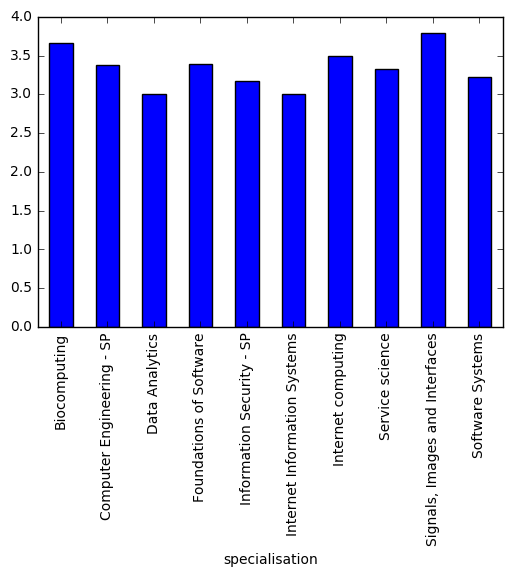

In [319]:
msc_agg_spe.reset_index().groupby(['specialisation'])['semester_count'].mean().plot(kind = 'bar')